In [1]:
# importing the neccessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import floor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

In [2]:
# Load the Excel file
file_path = 'CreditRisk_Data.xls'

# Load the sheets into separate dataframes
df_data = pd.read_excel(file_path, sheet_name=0)

# Display the first few rows of each dataframe to understand their structure
print('Data Sheet Head:')
df_data.head()


Data Sheet Head:


,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO/TV,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67.0,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22.0,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49.0,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45.0,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53.0,0,0,0,2,2,2,0,0,0


## Exploratory Data Analysis

In [3]:
# Modify column headers using list comprehension to replace headers to lowercase 
df_data.columns = [col.lower() for col in df_data.columns]
df_data.head()

,obs#,chk_acct,duration,history,new_car,used_car,furniture,radio/tv,education,retraining,...,age,other_install,rent,own_res,num_credits,job,num_dependents,telephone,foreign,response
0,1,0,6,4,0,0,0,1,0,0,...,67.0,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22.0,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49.0,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45.0,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53.0,0,0,0,2,2,2,0,0,0


In [4]:
# dropping the first columns since it is not necesary for the analysis
df_data.drop('obs#', axis=1, inplace = True)

In [5]:
# Check data types, missing values, and basic statistics for the data sheet
data_info = df_data.info()
missing_values = df_data.isnull().sum()
basic_stats = df_data.describe()
print('\
Missing Values:')
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chk_acct          1000 non-null   int64  
 1   duration          1000 non-null   int64  
 2   history           1000 non-null   int64  
 3   new_car           1000 non-null   int64  
 4   used_car          1000 non-null   int64  
 5   furniture         1000 non-null   int64  
 6   radio/tv          1000 non-null   int64  
 7   education         1000 non-null   int64  
 8   retraining        1000 non-null   int64  
 9   amount            1000 non-null   int64  
 10  sav_acct          1000 non-null   int64  
 11  employment        1000 non-null   int64  
 12  install_rate      1000 non-null   int64  
 13  male_div          999 non-null    float64
 14  male_single       1000 non-null   int64  
 15  male_mar_or_wid   1000 non-null   int64  
 16  co-applicant      999 non-null    float64
 

Handling missing values

In [6]:
# Handle missing values
df_data['male_div'].fillna(df_data['male_div'].mode()[0], inplace=True)
df_data['co-applicant'].fillna(df_data['co-applicant'].mode()[0], inplace=True)
df_data['age'].fillna(df_data['age'].median(), inplace=True)

print("Missing values after handling:")
print(df_data.isnull().sum())

Missing values after handling:
chk_acct            0
duration            0
history             0
new_car             0
used_car            0
furniture           0
radio/tv            0
education           0
retraining          0
amount              0
sav_acct            0
employment          0
install_rate        0
male_div            0
male_single         0
male_mar_or_wid     0
co-applicant        0
guarantor           0
present_resident    0
real_estate         0
prop_unkn_none      0
age                 0
other_install       0
rent                0
own_res             0
num_credits         0
job                 0
num_dependents      0
telephone           0
foreign             0
response            0
dtype: int64


Outlier capping

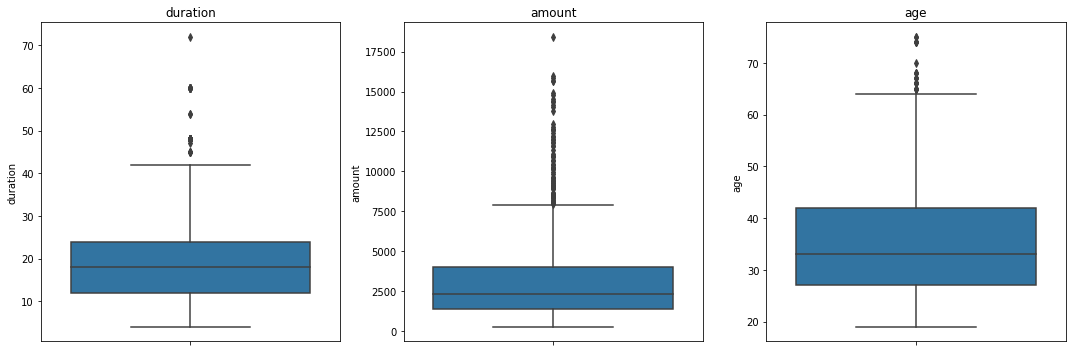

In [7]:
#Plot boxplots for numerical features to identify outliers
numerical_features = ['duration', 'amount','age']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_data[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

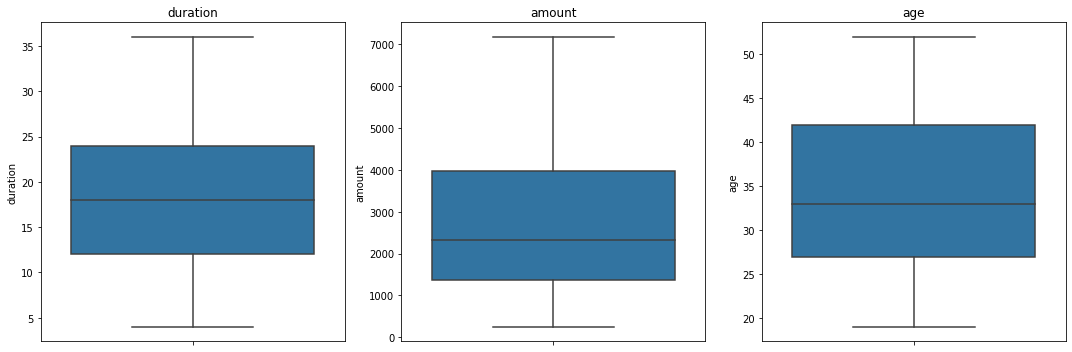

In [8]:
# Handle outliers by capping at the 90th percentile
for feature in ['duration', 'amount','age']:
    cap_value = df_data[feature].quantile(0.90)
    df_data[feature] = df_data[feature].apply(lambda x: min(x, cap_value))
numerical_features = ['duration', 'amount','age']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_data[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

Feature Engineering

In [9]:
# Feature Engineering
# we can combine feature like radio/tv, furniture and telephone to create new feature called household_items
# we can just sum up to find the feature since all stated features are binary categorical data tyoes
df_data['household_items'] = df_data['radio/tv'] + df_data['furniture'] + df_data['telephone']
df_data.head()

,chk_acct,duration,history,new_car,used_car,furniture,radio/tv,education,retraining,amount,...,other_install,rent,own_res,num_credits,job,num_dependents,telephone,foreign,response,household_items
0,0,6.0,4,0,0,0,1,0,0,1169.0,...,0,0,1,2,2,1,1,0,1,2
1,1,36.0,2,0,0,0,1,0,0,5951.0,...,0,0,1,1,2,1,0,0,0,1
2,3,12.0,4,0,0,0,0,1,0,2096.0,...,0,0,1,1,1,2,0,0,1,0
3,0,36.0,2,0,0,1,0,0,0,7179.4,...,0,0,0,1,2,2,0,0,1,1
4,0,24.0,3,1,0,0,0,0,0,4870.0,...,0,0,0,2,2,2,0,0,0,0


In [10]:
# in order to avoid multicollinearity we will drop the summed features
df_data.drop(['radio/tv', 'furniture','telephone'], axis=1, inplace= True)

## Visualization

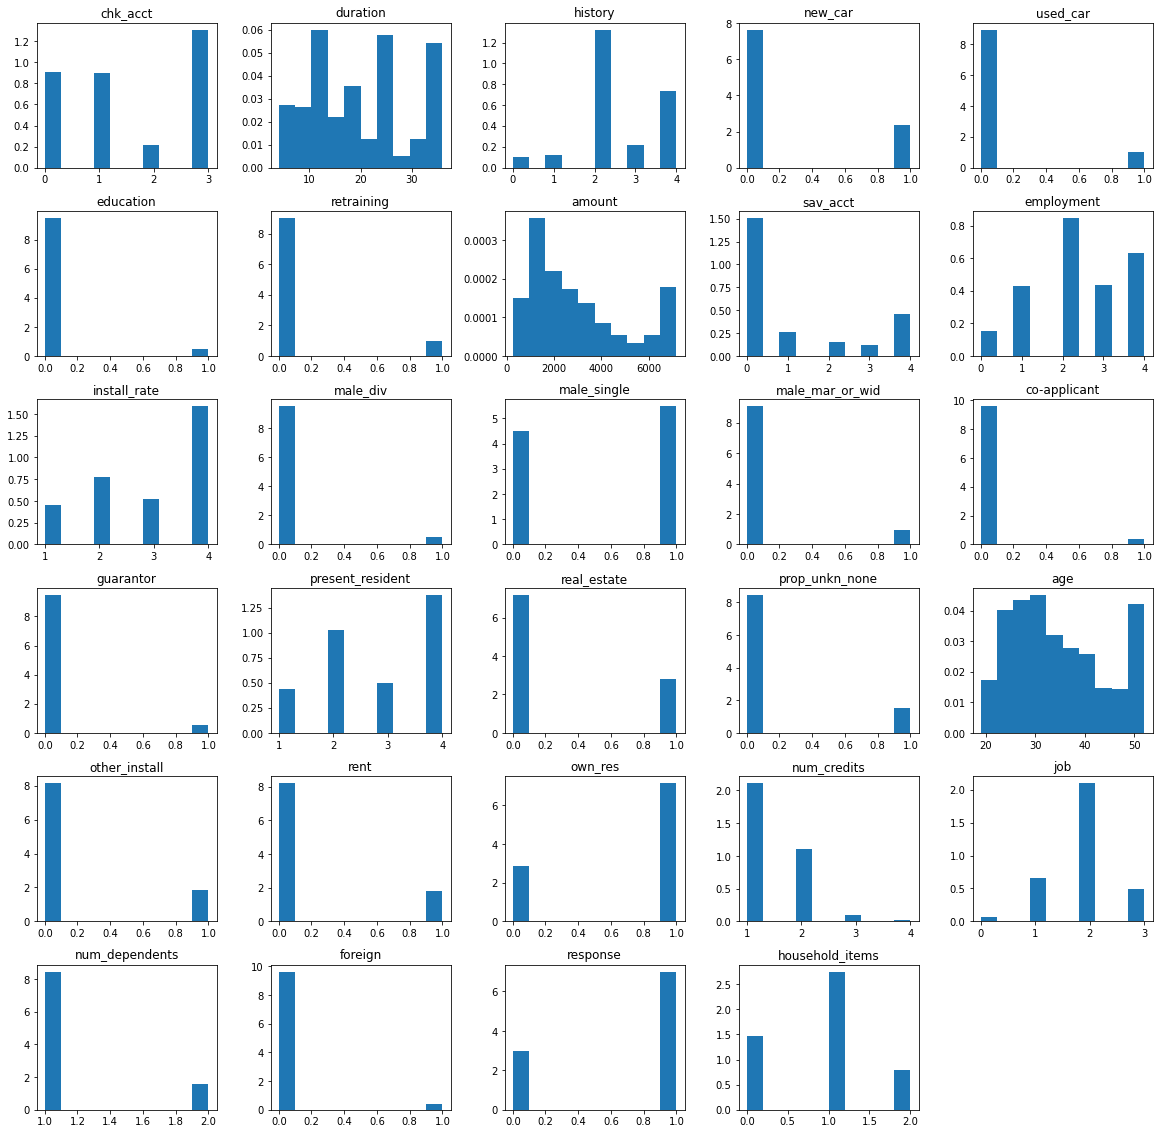

In [11]:
#As the data is free of missing values and outliers and has proper data types, we can 
#perform some advanced EDA by visualizing it.
#We create a histogram for the numerical columns to understand their distribution.
df_data.hist(figsize=(20, 20), grid=False, density=True)
plt.show()

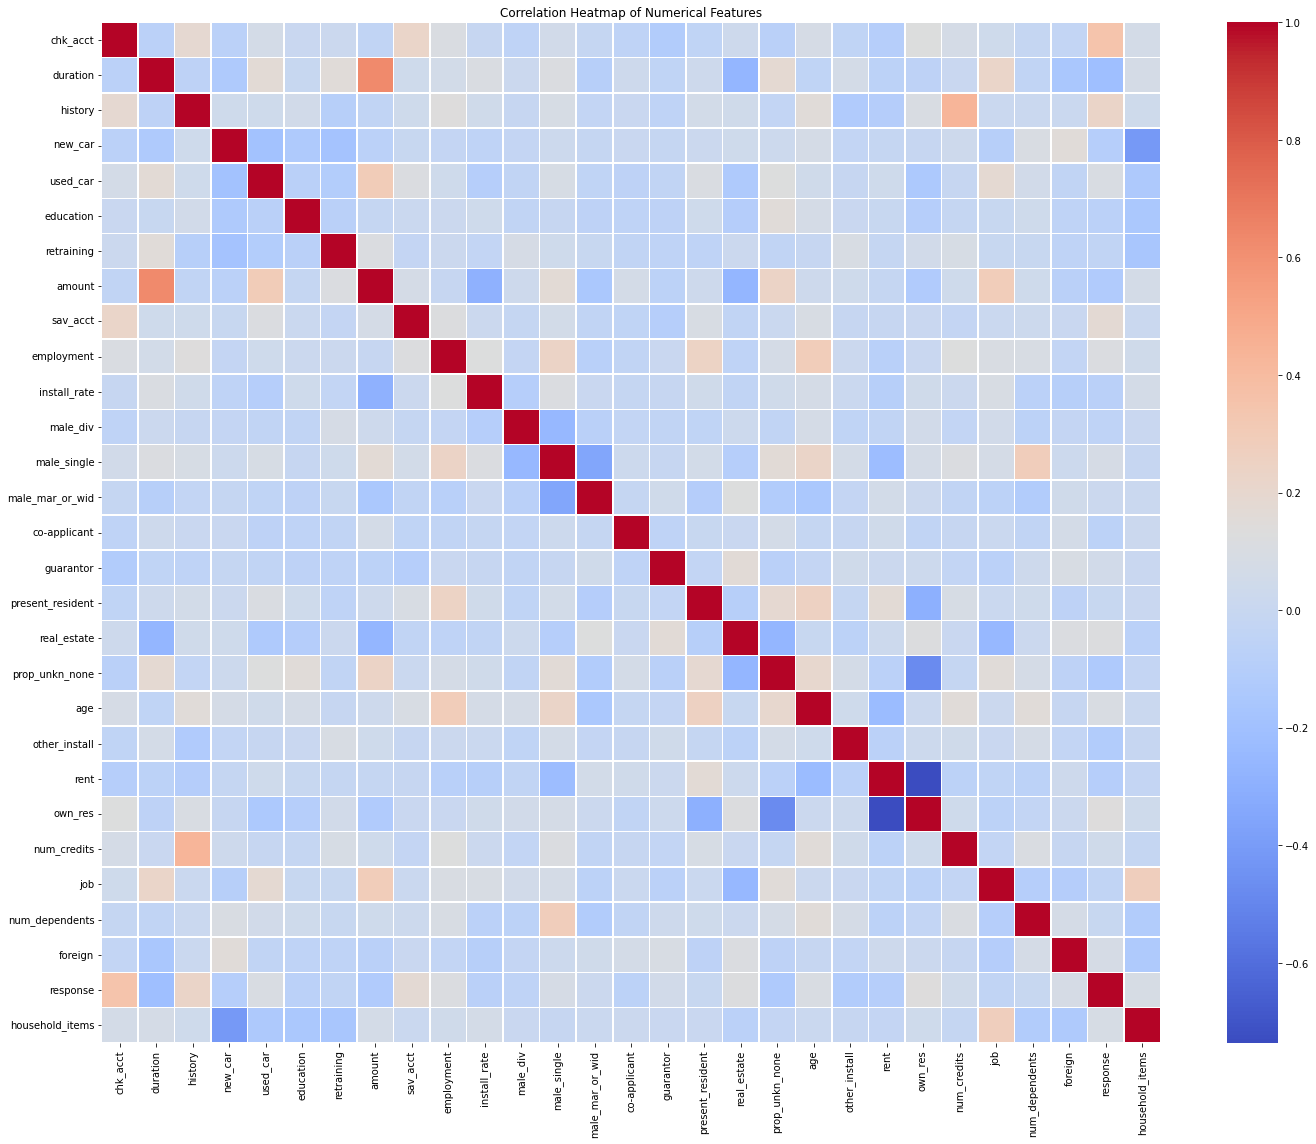

In [12]:
# Select numerical columns for correlation analysis
numerical_columns = df_data.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix
correlation_matrix = df_data[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

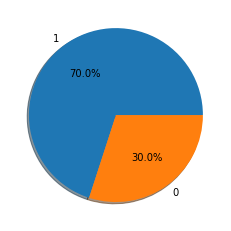

In [13]:
#It’s time to check if we are dealing with balanced data, which we do by
# understanding the distribution of the target variable using a pie chart.
response_vals = df_data.response.value_counts().index
response_labels = df_data.response.value_counts().values
plt.pie(data = df_data,x = response_labels, labels = response_vals,autopct = '%1.1f%%', shadow = True, radius = 1)
plt.show()

The data seems unbalanced. Next, we create a few bar charts to understand the
interactions between categorical columns.

In [14]:
def create_stacked_bar_crosstab(data, cat_col1, cat_col2, rotation_val=0): 
    pd.crosstab(data[cat_col1], data[cat_col2]).plot(kind='bar', stacked=True) # creating cross tab between two variables
    plt.title(f'{cat_col1} & {cat_col2} Distribution') # adding title
    plt.xlabel(f'{cat_col1}') # adding x and y label
    plt.ylabel('Number of Observations')
    plt.xticks(rotation = rotation_val) # option for rotating xticks
    plt.show()

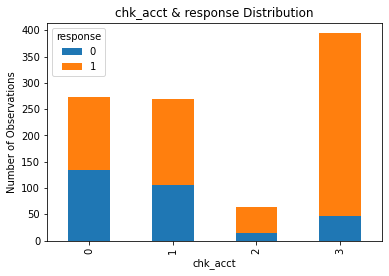

In [21]:
#Next, we will understand the interaction between Checking account status and Credit rating.
create_stacked_bar_crosstab(data = df_data, cat_col1 = 'chk_acct', cat_col2 = 'response', rotation_val = 90)

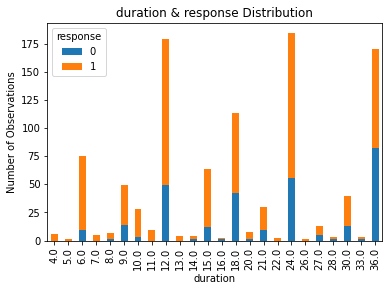

In [15]:
#Next, we will understand the interaction between duration of credit in months and Credit rating.
create_stacked_bar_crosstab(data = df_data, cat_col1 = 'duration', cat_col2 = 'response', rotation_val = 90)

## Feature reduction

In [16]:
# We now find the important variables using tree-based and statistical methods like
# Random Forest, Recursive Feature Elimination (RFE), and Univariate Analysis.
# extracting the predictor variables
X = df_data.drop('response', axis=1)
# extracting the target variable
y = df_data['response']
# Method 1: finding feature importance using Tree-Based method
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_
top_10_rf = X.columns[feature_importances.argsort()[-10:][::-1]]
# Method 2: using Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10,
step=1)
rfe_selector.fit(X, y)
top_10_rfe = X.columns[rfe_selector.support_]
# Method 3: using Univariate Feature Selection
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
top_10_univariate = X.columns[selector.get_support()]
#The following are the top 10 variables from each method.
print("Top 10 variables from Tree-Based Method:", ', '.join(top_10_rf))
print("---------------------")
print("Top 10 variables from Method Recursive Feature Elimination:", ','.join(top_10_rfe))
print("-------------------")
print("Top 10 variables from Univariate Feature Selection:", ','.join(top_10_univariate))

Top 10 variables from Tree-Based Method: amount, chk_acct, age, duration, history, employment, sav_acct, install_rate, present_resident, household_items
---------------------
Top 10 variables from Method Recursive Feature Elimination: chk_acct,duration,history,amount,sav_acct,employment,install_rate,present_resident,age,job
-------------------
Top 10 variables from Univariate Feature Selection: chk_acct,duration,history,amount,sav_acct,employment,real_estate,prop_unkn_none,other_install,own_res


In [17]:
# to check if any string-based column is left in the data
df_data.dtypes[df_data.dtypes=='object']

Series([], dtype: object)

In [18]:
# We find the important columns by picking only those that appear in at least one of
# the feature selection method’s outputs.
imp_columns = list(set(top_10_rf.tolist() + top_10_rfe.tolist() +top_10_univariate.tolist()))
imp_columns

['employment',
 'real_estate',
 'amount',
 'own_res',
 'duration',
 'prop_unkn_none',
 'household_items',
 'sav_acct',
 'job',
 'chk_acct',
 'install_rate',
 'other_install',
 'age',
 'history',
 'present_resident']

In [19]:
print('Number of selected columns are: ', len(imp_columns))

Number of selected columns are:  15


## Checking multicollinearity

In [20]:
#Some of the current 15 features might be related, causing multicollinearity. We,
# therefore, find and drop such features.
# extracting the selected independent features
X = df_data[imp_columns]
# creating correlation matrix
correlation_matrix = X.corr()
# finding highly correlated feature pairs
highly_correlated_pairs = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1)
print("Highly correlated pairs of variables and their correlation values:\n")
checked_pairs = set() # To keep track of checked pairs
for col1 in X.columns:
    for col2 in X.columns:
        if col1 != col2 and (col1, col2) not in checked_pairs and (col2, col1) not in checked_pairs:
            if highly_correlated_pairs.loc[col1, col2]:
                correlation_value = correlation_matrix.loc[col1, col2]
                print(f"{col1} - {col2}: {correlation_value:.2f}")
                checked_pairs.add((col1, col2))

Highly correlated pairs of variables and their correlation values:



We use correlation to check for multicollinearity and mark
the columns where the absolute correlation value is above 0.7. and found none

## Train-test split

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Scaling data

In [22]:
# normalizing data using min-max scaler
from sklearn.preprocessing import MinMaxScaler
# initializing min-max scaler
scaler = MinMaxScaler()
# fitting it onto the independent features
X = scaler.fit_transform(X)


Balancing data

In [24]:
# We are dealing with class-imbalanced data, as evidenced earlier thus We used the SMOTE method, where synthetic samples are created for the minority
# classes to balance the classes.
# initializing SMOTE
smote = SMOTE()
# fitting SMOTE to the data
X, y = smote.fit_resample(X, y)

## Finding best model and Fitting best model

We will first build a function that is easy to use for different models that we are going to experiment with. The 'grid_search_best_model' function is designed to perform hyperparameter tuning and identify the best-performing machine learning model within a specified parameter grid. It takes as input the 'model' to be optimized, a set of 'params' representing the hyperparameter grid to search over, the 'k_fold' cross- validation strategy for model evaluation, the training data 'X_train' and corresponding target values 'y_train.' Inside the function, GridSearchCV is utilized to exhaustively search the hyperparameter grid, fitting the model with different parameter combinations while using k-fold cross-validation to assess performance. Let us define two more functions evaluating and comparing the performance of machine learning classifiers models. the score_model function to use classification metrics: accuracy, precision, recall, f1_score, and roc_auc_score to evalute each model and the compare_results function to compare classification metrics across different models.

In [25]:
def grid_search_best_model(model, params, k_fold, X_train, y_train):
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, params, cv=k_fold).fit(X_train, y_train)
    print("Best params:", grid_search.best_params_)
    print("Best estimator:", grid_search.best_estimator_)
    print("Best score (Cross-Validated Accuracy):", grid_search.best_score_)
    return grid_search.best_estimator_

model_results = {}

def score_model(model, X_train, X_test, y_train, y_test, show_plot=True):
    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Predict probabilities for ROC AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc}")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }

def compare_results():
    # Compare the results of different models
    for key in model_results:
        print(f"Model: {key}")
        print("Accuracy:", model_results[key]["accuracy"])
        print("Precision:", model_results[key]["precision"])
        print("Recall:", model_results[key]["recall"])
        print("F1 Score:", model_results[key]["f1_score"])
        print("AUC-ROC:", model_results[key]["auc"])
        print()

In [26]:
# Define the parameter grids for different classifiers
params_ada = {  'n_estimators': [50, 100, 300, 500, 700, 1000], 'learning_rate': [0.01, 0.05, 0.1, 1]}

params_rf = { 'n_estimators': [50, 100, 300], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}

params_gbc = { 'n_estimators': [50, 100, 300],  'learning_rate': [0.01, 0.1, 0.5],  'max_depth': [3, 5, 7]}

params_knn = { 'n_neighbors': range(3, 15), 'leaf_size': [20, 30, 40]}

In [27]:
 #Train and evaluate AdaBoost Classifier
ada_clf = grid_search_best_model(AdaBoostClassifier(), params_ada, 5, X_train, y_train)
model_results['AdaBoost'] = score_model(ada_clf, X_train, X_test, y_train, y_test)

Best params: {'learning_rate': 0.1, 'n_estimators': 100}
Best estimator: AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
Best score (Cross-Validated Accuracy): 0.7385714285714287
Accuracy: 0.7366666666666667
Precision: 0.75390625
Recall: 0.9234449760765551
F1 Score: 0.8301075268817204
AUC-ROC: 0.7859771807140229


In [28]:
# Train and evaluate Random Forest Classifier
rf_clf = grid_search_best_model(RandomForestClassifier(), params_rf, 5, X_train, y_train)
model_results['Random Forest'] = score_model(rf_clf, X_train, X_test, y_train, y_test)

Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best estimator: RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300)
Best score (Cross-Validated Accuracy): 0.7685714285714285
Accuracy: 0.76
Precision: 0.7707509881422925
Recall: 0.9330143540669856
F1 Score: 0.8441558441558442
AUC-ROC: 0.7834270992165729


In [35]:
# Train and evaluate Gradient Boosting Classifier
gbc_clf = grid_search_best_model(GradientBoostingClassifier(), params_gbc, 5, X_train, y_train)
model_results['Gradient Boosting'] = score_model(gbc_clf, X_train, X_test, y_train, y_test)

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best estimator: GradientBoostingClassifier(n_estimators=50)
Best score (Cross-Validated Accuracy): 0.76
Accuracy: 0.7466666666666667
Precision: 0.7714285714285715
Recall: 0.9043062200956937
F1 Score: 0.8325991189427313
AUC-ROC: 0.7775382512224617


In [29]:
# Train and evaluate K-Nearest Neighbors Classifier
knn_clf = grid_search_best_model(KNeighborsClassifier(), params_knn, 5, X_train, y_train)
model_results['KNN'] = score_model(knn_clf, X_train, X_test, y_train, y_test)

Best params: {'leaf_size': 20, 'n_neighbors': 13}
Best estimator: KNeighborsClassifier(leaf_size=20, n_neighbors=13)
Best score (Cross-Validated Accuracy): 0.74
Accuracy: 0.7266666666666667
Precision: 0.7529880478087649
Recall: 0.9043062200956937
F1 Score: 0.8217391304347826
AUC-ROC: 0.7423891897576108


In [38]:
from sklearn.neural_network import MLPClassifier
# Define the MLPClassifier (Neural Network)
mlp = MLPClassifier(max_iter=1000)

# Define the parameter grid for hyperparameter tuning
params= {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}
# Perform Grid Search with cross-validation to find the best parameters
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=5)
model_results['grid_search']= grid_search.fit(X_train, y_train)

In [36]:
# Output the best parameters and estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)

# Use the best estimator to predict on the test data
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)
y_pred_proba = best_mlp.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best estimator:  MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              max_iter=1000, solver='sgd')
Accuracy: 0.7467
Precision: 0.7854
Recall: 0.8756
F1 Score: 0.8281
AUC-ROC: 0.8004


Based on the performance metrics provided for different models used in the credit rating classification, here's an analysis and comparison of their effectiveness:

### **Performance Comparison of Models:**

1. **AdaBoost:**
   - **Accuracy:** 0.737
   - **Precision:** 0.754
   - **Recall:** 0.923
   - **F1 Score:** 0.830
   - **AUC-ROC:** 0.786

   **Analysis:** 
   - AdaBoost shows a high recall (0.923), meaning it is very effective at correctly identifying true positives (e.g., customers likely to default). 
   - The F1 score and precision are relatively high, indicating a good balance between precision and recall. 
   - It has a slightly lower accuracy compared to Random Forest but performs well overall.

2. **Random Forest:**
   - **Accuracy:** 0.760
   - **Precision:** 0.771
   - **Recall:** 0.933
   - **F1 Score:** 0.844
   - **AUC-ROC:** 0.783

   **Analysis:**
   - Random Forest has the highest accuracy (0.760) and a strong recall (0.933), indicating it effectively captures the positive cases.
   - The F1 score is the highest among all models (0.844), which reflects a good trade-off between precision and recall.
   - The AUC-ROC is slightly lower than AdaBoost and Neural Network, suggesting slightly less effective discrimination between classes.

3. **K-Nearest Neighbors (KNN):**
   - **Accuracy:** 0.727
   - **Precision:** 0.753
   - **Recall:** 0.904
   - **F1 Score:** 0.822
   - **AUC-ROC:** 0.742

   **Analysis:**
   - KNN has the lowest accuracy (0.727) and AUC-ROC (0.742) among all models, indicating it may not be the best choice for this classification task.
   - While the recall is still high (0.904), suggesting that it captures a fair amount of positives, its precision and F1 score are lower than those of other models.

4. **Neural Network:**
   - **Accuracy:** 0.747
   - **Precision:** 0.785
   - **Recall:** 0.876
   - **F1 Score:** 0.828
   - **AUC-ROC:** 0.800

   **Analysis:**
   - The Neural Network model demonstrates a good balance between all metrics with an AUC-ROC of 0.800, the highest among all models.
   - It has a higher precision (0.785) compared to other models except for Random Forest, indicating fewer false positives.
   - The recall (0.876) and F1 score (0.828) are strong, making it a reliable model for predicting credit ratings.

5. **Gradient Boosting:**
   - **Accuracy:** 0.747
   - **Precision:** 0.771
   - **Recall:** 0.904
   - **F1 Score:** 0.833
   - **AUC-ROC:** 0.778

   **Analysis:**
   - Gradient Boosting shows comparable performance to the Neural Network with similar accuracy (0.747) and slightly lower AUC-ROC (0.778).
   - It has a good balance of precision and recall, making it a solid choice for classification, especially where high recall is important.

### **Conclusion:**

- **Best Performing Model:** The **Neural Network** model shows the best overall performance in terms of AUC-ROC (0.800), which is critical for evaluating how well the model distinguishes between classes. It also maintains a strong balance across all metrics, making it a reliable choice for credit rating classification.
  
- **Alternative Choices:** The **Random Forest** and **Gradient Boosting** models are also strong contenders, with high accuracy and F1 scores. If interpretability and stability are crucial, Random Forest might be preferred due to its robustness and ease of understanding.

- **Less Effective Models:** The **KNN** model has the lowest performance among all metrics, indicating that it may not be suitable for this task.

In summary, the Neural Network appears to be the best model for credit rating classification based on the provided metrics, closely followed by Random Forest and Gradient Boosting.

## Evaluating model

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        91
           1       0.79      0.88      0.83       209

    accuracy                           0.75       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.74      0.75      0.74       300



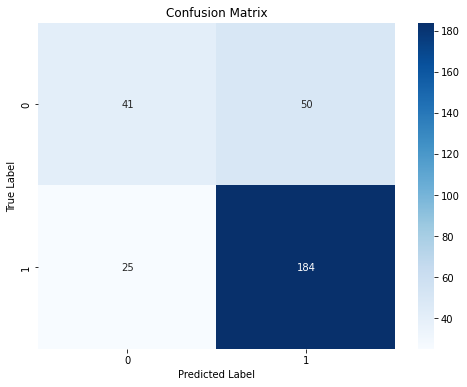

In [40]:
f_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive', max_iter=1000, solver='sgd')
f_model.fit(X_train, y_train)

# Make predictions
y_pred = f_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


The classification report provides a detailed evaluation of the performance of a Neural Network model on a binary classification task where the goal is to classify credit ratings as "good" (1) or "not good" (0). Here is an explanation of the metrics in the report:

### **Classification Report Metrics:**

1. **Precision**:
   - Precision is the ratio of correctly predicted positive observations to the total predicted positives.
   - For class 0 (not good credit rating): Precision is 0.62, meaning that when the model predicts a credit rating is not good, it is correct 62% of the time.
   - For class 1 (good credit rating): Precision is 0.79, meaning that when the model predicts a credit rating is good, it is correct 79% of the time.

2. **Recall**:
   - Recall (also known as sensitivity or true positive rate) is the ratio of correctly predicted positive observations to all observations in the actual class.
   - For class 0: Recall is 0.45, meaning the model correctly identifies 45% of all actual "not good" credit ratings.
   - For class 1: Recall is 0.88, meaning the model correctly identifies 88% of all actual "good" credit ratings.

3. **F1-Score**:
   - The F1-score is the weighted average of precision and recall, providing a single metric that balances both concerns.
   - For class 0: The F1-score is 0.52, which indicates a moderate balance between precision and recall for the "not good" credit rating.
   - For class 1: The F1-score is 0.83, indicating a good balance between precision and recall for the "good" credit rating.

4. **Support**:
   - Support is the number of actual occurrences of each class in the specified dataset.
   - There are 91 instances of class 0 (not good credit rating) and 209 instances of class 1 (good credit rating).

5. **Accuracy**:
   - Accuracy is the ratio of correctly predicted observations to the total observations.
   - The accuracy of the model is 0.75, meaning that 75% of the total predictions (both classes combined) are correct.

6. **Macro Average**:
   - Macro average calculates the average of precision, recall, and F1-score across both classes, treating all classes equally.
   - Precision (macro avg): 0.70
   - Recall (macro avg): 0.67
   - F1-score (macro avg): 0.68
   - These scores suggest that when treating both classes equally, the model has moderate performance, especially since there is some imbalance in recall and precision between the two classes.

7. **Weighted Average**:
   - Weighted average takes into account the support (the number of instances for each class) while calculating the average.
   - Precision (weighted avg): 0.74
   - Recall (weighted avg): 0.75
   - F1-score (weighted avg): 0.74
   - These scores indicate that the model performs better on the majority class (class 1) due to its higher support (more instances in the dataset).

### **Interpretation and Key Insights:**

- **Class Imbalance Handling:** The model shows better performance (higher precision, recall, and F1-score) for class 1 ("good" credit rating) compared to class 0 ("not good" credit rating). This could be due to the fact that there are more instances of class 1 in the dataset (209 vs. 91), leading the model to be more optimized for class 1.

- **Room for Improvement:** The model’s lower recall for class 0 (0.45) indicates that it misses a significant number of "not good" credit ratings, potentially leading to false negatives where the model incorrectly classifies some "not good" credit ratings as "good."

- **Overall Performance:** The accuracy of 0.75 shows that the model correctly predicts 75% of the instances. However, the imbalance between precision and recall for class 0 suggests that the model could benefit from additional tuning or data augmentation techniques to improve its sensitivity to the minority class.

- **Potential Actions:** To improve the model:
  - **Address Class Imbalance:** Techniques such as oversampling the minority class (class 0), undersampling the majority class (class 1), or using synthetic data generation methods (like SMOTE) could help.
  - **Feature Engineering:** Adding more relevant features or transforming existing ones could help the model better differentiate between the classes.
  - **Model Optimization:** Further tuning the hyperparameters of the Neural Network or experimenting with different architectures (like deeper networks or different activation functions) might improve the model's performance on class 0.

Overall, the model performs reasonably well, particularly in predicting "good" credit ratings, but there is an opportunity to enhance its performance in identifying "not good" credit ratings.